<a href="https://colab.research.google.com/github/SP-2-Red-Data-Mining-and-AI/solid-bassoon/blob/main/LA_CrimeAnalysis.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
import pandas as pd
import numpy as np

from sklearn.preprocessing import MinMaxScaler
from sklearn.preprocessing import StandardScaler
from sklearn.cluster import KMeans
from sklearn.cluster import DBSCAN
from sklearn.cluster import AgglomerativeClustering
from sklearn.metrics import silhouette_score
from sklearn.neighbors import NearestNeighbors

from sklearn.decomposition import PCA

from scipy.stats import gaussian_kde

from mlxtend.frequent_patterns import apriori, association_rules
from mlxtend.preprocessing import TransactionEncoder

import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D
from matplotlib.animation import FuncAnimation

import plotly.graph_objects as go

import folium
from folium.plugins import HeatMap
from folium.plugins import MarkerCluster
from folium.plugins import TimestampedGeoJson
from folium.plugins import HeatMapWithTime

from IPython.display import IFrame
from IPython.display import display
from IPython.display import HTML
from ipywidgets import IntProgress

from abc import ABC, abstractmethod

In [ ]:
#some useful functions for allowing pandas dataframes to be fully displayed
def pandas_unlimited_output():
    pd.set_option('display.max_rows', None)
    pd.set_option('display.max_columns', None)
    pd.set_option('display.width', None)
    pd.set_option('display.max_colwidth', None)
    pd.set_option('display.expand_frame_repr', False)

def pandas_default_output():
    pd.reset_option('display.max_rows')
    pd.reset_option('display.max_columns')
    pd.reset_option('display.width')
    pd.reset_option('display.max_colwidth')
    pd.reset_option('display.expand_frame_repr')


In [ ]:
#abstract data manager class
class DataManager(ABC):

    @abstractmethod
    def __init__(self):
        pass

    @abstractmethod
    def load_raw_data(self):
        pass

    @abstractmethod
    def clean_data(self):
        pass

    @abstractmethod
    def get_data_in_range(self):
        pass

    @abstractmethod
    def get_transactions(self):
        pass

In [ ]:
#handles the la dataset, functions tailored to work with it
class LADataManager(DataManager):

    def __init__(self):
        self.raw_data = self.load_raw_data()
        self.clean_data()

    def load_raw_data(self, print_cols = False):

        dataset_name = 'Crime_data_from_2020_to_Present.csv'
        raw_data = pd.read_csv(dataset_name)

        #from crime desc, weapon desc, and premis desc, remove portions contained in parentheses
        raw_data['Crm Cd Desc'] = raw_data['Crm Cd Desc'].str.replace(r"\(.*\)","")
        raw_data['Weapon Desc'] = raw_data['Weapon Desc'].str.replace(r"\(.*\)","")
        raw_data['Premis Desc'] = raw_data['Premis Desc'].str.replace(r"\(.*\)","")

        #create tables for crime, weapon, and premises descriptions along with their code
        #find the desc for each cd, dont include original index
        crime_desc = raw_data[['Crm Cd', 'Crm Cd Desc']].drop_duplicates().reset_index(drop=True).sort_values(by='Crm Cd').set_index('Crm Cd')
        weapon_desc = raw_data[['Weapon Used Cd', 'Weapon Desc']].drop_duplicates().reset_index(drop=True).sort_values(by='Weapon Used Cd')
        premis_desc = raw_data[['Premis Cd', 'Premis Desc']].drop_duplicates().reset_index(drop=True).sort_values(by='Premis Cd')

        #drop codes with nan descriptions
        crime_desc = crime_desc.dropna()
        weapon_desc = weapon_desc.dropna()
        premis_desc = premis_desc.dropna()

        self.weapon_desc_dict = weapon_desc.set_index('Weapon Used Cd').to_dict()['Weapon Desc']
        self.crime_desc_dict = crime_desc.to_dict()['Crm Cd Desc']
        self.premis_desc_dict = premis_desc.set_index('Premis Cd').to_dict()['Premis Desc']

        if print_cols:
            print(raw_data.columns)

        return raw_data

    #processes the raw data into a dataframe filled with normalized and encoded data
    def clean_data(self):
        #take only the columns we need:
        #DATE OCC, TIME OCC, Crm Cd, Weapon Used Cd, Premis Cd, LAT, LON
        data = self.raw_data[['DATE OCC', 'TIME OCC', 'Crm Cd', 'Weapon Used Cd', 'Premis Cd', 'LAT', 'LON']].copy()

        df_crime_cd_desc_labels = pd.read_excel('crime_cd_desc_labels.xlsx')
        crime_cd_desc_map = df_crime_cd_desc_labels.set_index('Crm Cd').to_dict(orient='index')

        #df_premis_cd_desc_labels = pd.read_excel('premis_cd_desc_labels.xlsx')
        #create a map that maps Premis Cd to Premis Desc
        #premis_cd_desc_map = df_premis_cd_desc_labels.set_index('Premis Cd').to_dict()['Premis Desc']

        #create a new column for the primary and secondary crime labels
        data['Crm Primary'] = data['Crm Cd'].map(lambda x: crime_cd_desc_map[x]['Crm Primary'])
        data['Crm Secondary'] = data['Crm Cd'].map(lambda x: crime_cd_desc_map[x]['Crm Secondary'])

        #process time data to be a single datetime column
        data['DATE OCC'] = pd.to_datetime(data['DATE OCC'])
        data['TIME OCC'] = data['TIME OCC'].apply(lambda x: str(x).zfill(4))

        data['datetime'] = pd.to_datetime(data['DATE OCC']) \
            + pd.to_timedelta(data['TIME OCC'].apply(lambda x: int(x[:2])), unit='h') \
            + pd.to_timedelta(data['TIME OCC'].apply(lambda x: int(x[2:])), unit='m')

        data.drop(columns=['DATE OCC', 'TIME OCC'], inplace=True)

        #time feaures to extract:
        #day of week (cyclical)
        #hour of day (cyclical)
        #month of year (cyclical)
        #year normalized

        #hour of day
        data['hour_sin'] = np.sin(2 * np.pi * data['datetime'].dt.hour / 24)
        data['hour_cos'] = np.cos(2 * np.pi * data['datetime'].dt.hour / 24)
        data['hour'] = data['datetime'].dt.hour

        #day of week
        data['day_of_week_sin'] = np.sin(2 * np.pi * data['datetime'].dt.dayofweek / 7)
        data['day_of_week_cos'] = np.cos(2 * np.pi * data['datetime'].dt.dayofweek / 7)
        data['day_of_week'] = data['datetime'].dt.dayofweek

        #month of year
        data['month_sin'] = np.sin(2 * np.pi * data['datetime'].dt.month / 12)
        data['month_cos'] = np.cos(2 * np.pi * data['datetime'].dt.month / 12)
        data['month'] = data['datetime'].dt.month

        #day of year
        data['day_of_year_sin'] = np.sin(2 * np.pi * data['datetime'].dt.dayofyear / 365)
        data['day_of_year_cos'] = np.cos(2 * np.pi * data['datetime'].dt.dayofyear / 365)
        data['day_of_year'] = data['datetime'].dt.dayofyear

        #year
        year_scaler = MinMaxScaler()
        data['year'] = year_scaler.fit_transform(data['datetime'].dt.year.values.reshape(-1, 1))

        #drop the 10 rows where premis cd is nan
        data = data.dropna(subset=['Premis Cd'])

        #where weapon used cd is nan, replace with 0
        data['Weapon Used Cd'] = data['Weapon Used Cd'].fillna(0)
        self.weapon_desc_dict[0] = 'No Weapon Used'

        #make a new column 'weapon_exists' that is 1 if weapon used cd is not 0, else 0
        data['weapon_exists'] = data['Weapon Used Cd'].apply(lambda x: 1 if x != 0 else 0)

        #drop lat or lon vals that are 0
        data = data[(data['LAT'] != 0) & (data['LON'] != 0)]

        #normalize data
        scaler = MinMaxScaler()

        la_coords = (34.0522, -118.2437)

        #drop where lat or lon is more than 1 away from LA
        data = data[(data['LAT'] > la_coords[0] - 1) & (data['LAT'] < la_coords[0] + 1) & (data['LON'] > la_coords[1] - 1) & (data['LON'] < la_coords[1] + 1)]

        data['LAT'] = scaler.fit_transform(data['LAT'].values.reshape(-1, 1))
        self.lat_scaler = (scaler.data_min_, scaler.data_max_)

        data['LON'] = scaler.fit_transform(data['LON'].values.reshape(-1, 1))
        self.lon_scaler = (scaler.data_min_, scaler.data_max_)

        data['year'] = scaler.fit_transform(data['year'].values.reshape(-1, 1))
        self.year_scaler = (scaler.data_min_, scaler.data_max_)

        #encode categorical data and normalize
        cols_to_encode = ['Crm Cd', 'Weapon Used Cd', 'Premis Cd']
        for col in cols_to_encode:
            new_col_name = col + '_freq'
            freq_map = data[col].value_counts().to_dict()
            data[new_col_name] = data[col].map(freq_map)
            data[new_col_name] = scaler.fit_transform(data[new_col_name].values.reshape(-1, 1))

        self.data = data

    def get_data_in_range(self, start_date, end_date):
        return self.data[(self.data['datetime'] >= start_date) & (self.data['datetime'] <= end_date)]

    #for use with association data mining, transactions are a list of lists of strings (or discrete values) that occur together
    #returns a pd dataframe, for use in the association mining method, first apply values.tolist() to the dataframe
    def get_transactions(self, data):

        #discretize datetime into 6 hour intervals for time of day, day of week, and month
        #time of day: 9pm-3am night, 3am-9am morning, 9am-3pm noon, 3pm-9pm evening
        data['time_of_day'] = pd.cut(data['datetime'].dt.hour, bins=[0, 3, 9, 15, 21, 24], labels=['night', 'morning', 'noon', 'evening', 'night'], ordered=False)
        data['day_of_week'] = data['datetime'].dt.dayofweek
        data['month'] = data['datetime'].dt.month

        transactions = data[['Crm Cd', 'Crm Primary', 'Crm Secondary', 'Weapon Used Cd', 'Premis Cd', 'time_of_day', 'day_of_week', 'month']].copy()

        #convert cluster labels to string as "Cluster " + cluster_label
        if('cluster_label' in data.columns):
            transactions['cluster_label'] = data['cluster_label'].apply(lambda x: 'Cluster ' + str(x))

        #convert columns to string
        #use lookup tables for cd columns
        transactions['Crm Cd'] = transactions['Crm Cd'].map(self.crime_desc_dict)
        transactions['Weapon Used Cd'] = transactions['Weapon Used Cd'].map(self.weapon_desc_dict)
        transactions['Premis Cd'] = transactions['Premis Cd'].map(self.premis_desc_dict)

        months_of_year = {1: 'Jan', 2: 'Feb', 3: 'Mar', 4: 'Apr', 5: 'May', 6: 'Jun', 7: 'Jul', 8: 'Aug', 9: 'Sep', 10: 'Oct', 11: 'Nov', 12: 'Dec'}
        days_of_week = {0: 'Mon', 1: 'Tue', 2: 'Wed', 3: 'Thu', 4: 'Fri', 5: 'Sat', 6: 'Sun'}

        transactions['month'] = transactions['month'].map(months_of_year)
        transactions['day_of_week'] = transactions['day_of_week'].map(days_of_week)

        transactions = transactions.astype(str)

        transactions = transactions.replace('nan', np.nan).dropna()

        return transactions

    def denormalize_lat_lon(self, data):
        #data is a numpy array with columns lat, lon
        #returns a numpy array with columns lat, lon
        lat_min, lat_max = self.lat_scaler
        lon_min, lon_max = self.lon_scaler

        data[:, 0] = data[:, 0] * (lat_max - lat_min) + lat_min
        data[:, 1] = data[:, 1] * (lon_max - lon_min) + lon_min
        return data


In [ ]:
#methods for processing data, independent of dataset

#clusters the given data using kmeans by the given columns
#columns for clustering should be continuous and normalized
#returns a new dataframe with a new column 'cluster_label' that contains the cluster label for each row as well as the cluster model
def cluster_kmeans(data, cluster_columns, cluster_count):

    X = data[cluster_columns]

    kmeans = KMeans(n_clusters=cluster_count, init='k-means++', max_iter=300, n_init=10, random_state=0)
    clusters = kmeans.fit_predict(X)

    data['cluster_label'] = clusters

    return data, kmeans

#takes awhile,  for just 2021 slice: eps = 0.1, min_samples = 10 ~6 min
#min samples affects the number of clusters, eps affects the size of the clusters
def cluster_DBSCAN(data, cluster_columns, eps, min_samples):

    X = data[cluster_columns]

    dbscan = DBSCAN(eps=eps, min_samples=min_samples)
    clusters = dbscan.fit_predict(X)

    data['cluster_label'] = clusters

    return data, dbscan

def cluster_agglomerative(data, cluster_columns, cluster_count):

    X = data[cluster_columns]

    agg = AgglomerativeClustering(n_clusters=cluster_count)
    clusters = agg.fit_predict(X)

    data['cluster_label'] = clusters

    return data, agg

#depending on size of transactions, this might take a while
#returns a dataframe of association rules from the given transactions list
def association_mining(transactions, min_support = 0.01, min_threshold = 0.5, metric = 'lift'):

    transactions = transactions.values.tolist()

    #create the encoder
    te = TransactionEncoder()
    te_ary = te.fit(transactions).transform(transactions)
    df = pd.DataFrame(te_ary, columns=te.columns_)

    #run apriori
    frequent_itemsets = apriori(df, min_support=min_support, use_colnames=True)

    #run association rules
    rules = association_rules(frequent_itemsets, metric=metric, min_threshold=min_threshold)

    return rules

#returns a new dataframe reduced via PCA based on the given columns and number of components
#columns used should be continuous and normalized
def get_pca(data, n_components, columns):

    pca_features = data[columns]

    scaler = StandardScaler()
    pca_features_scaled = scaler.fit_transform(pca_features)

    pca = PCA(n_components = n_components)
    X_pca = pca.fit_transform(pca_features_scaled)

    return X_pca, pca

#samples a given fraction of the data and calculates the gaussian kde
#returns the sampled data and the density values
def get_gaussian_kde(data, cols, sample_frac, log=False):

    assert len(cols) == 2 or len(cols) == 3, 'cols must be a list of 2 or 3 column names'

    #time complexity of gaussian_kde is O(N^2 * D) where N is the number of points and D is the number of dimensions
    #at 0.01 sample frac and 3 dimensions, it takes roughly 4 seconds
    #to do the entire dataset in 3 dimensions, it would take 4 * 100^2 = 40000 seconds = ~11 hours

    data_sampled = data.sample(frac=sample_frac).reset_index(drop=True)

    if len(cols) == 2:
        xyz = np.vstack([data_sampled[cols[0]], data_sampled[cols[1]]])
    elif len(cols) == 3:
        xyz = np.vstack([data_sampled[cols[0]], data_sampled[cols[1]], data_sampled[cols[2]]])

    if log: print('begining density calculation')
    density = gaussian_kde(xyz)(xyz)
    if log: print('density calculation complete')

    return data_sampled, density

def get_crime_counts(data, column_to_count, freq='D'):
    return data.set_index('datetime')[column_to_count].resample(freq).count()

def process_association_rules(rules):
    #sort rules by lif
    modified = rules.sort_values(by='lift', ascending=False)
    #remove every other row
    modified = modified[::2]
    modified = modified.sort_values(by='leverage', ascending=False)

    #lift = associativity of antecedent and consequent, < 1 means they are less likely to occur together, > 1 means they are more likely to occur together
    #leverage = difference between observed frequency of antecedent and consequent together and what would be expected if they were independent, positive means they occur together more than expected
    #print ant, cons, lev, lift, conv
    #only print rows where lift distance from 1 is greater than 0.2
    print(modified[abs(modified['lift'] - 1) > 0.2][['antecedents', 'consequents', 'leverage', 'lift', 'conviction']])

In [ ]:
#VISUALIZATION FUNCTIONS

#plots the given data in 2d or 3d, with the given columns as x, y, and/or z
#optionally, c can be given as a column name to color the points by
def plot(data, columns, title, c=None, alpha=0.5, show=True, c_bar=True):

    two_dim = len(columns) == 2
    three_dim = len(columns) == 3

    assert two_dim or three_dim, 'columns must be a list of 2 or 3 column names'

    if two_dim:

        fig, ax = plt.subplots(1, 1, figsize=(10, 10))

        scatter = ax.scatter(data[columns[0]], data[columns[1]], s=50, alpha=0.5)

        if(c != None):
            scatter = ax.scatter(data[columns[0]], data[columns[1]], c=data[c], cmap='viridis', s=50, alpha=0.5)
            if c_bar: fig.colorbar(scatter, ax=ax, label=c)

        ax.set_xlabel(columns[0])
        ax.set_ylabel(columns[1])

    elif three_dim:

        fig = plt.figure(figsize=(10, 10))
        ax = fig.add_subplot(111, projection='3d')

        scatter = ax.scatter(data[columns[0]], data[columns[1]], data[columns[2]], cmap='viridis', s=50, alpha=alpha)

        if(c != None):
            scatter = ax.scatter(data[columns[0]], data[columns[1]], data[columns[2]], c=data[c], cmap='viridis', s=50, alpha=0.5)
            if c_bar: fig.colorbar(scatter, ax=ax, label=c)

        ax.set_xlabel(columns[0])
        ax.set_ylabel(columns[1])
        ax.set_zlabel(columns[2])

    ax.set_title(title)
    plt.legend()
    if show: plt.show()

def cluster_plot(data, columns, title, show=True):

    two_dim = len(columns) == 2
    three_dim = len(columns) == 3

    assert two_dim or three_dim, 'columns must be a list of 2 or 3 column names'
    assert 'cluster_label' in data.columns, 'data must have a column named cluster_label'

    if two_dim:
        fig, ax = plt.subplots(1, 1, figsize=(10, 10))

        ax.scatter(data[columns[0]], data[columns[1]], c=data['cluster_label'], cmap='viridis', s=50, alpha=0.5)

        ax.set_xlabel(columns[0])
        ax.set_ylabel(columns[1])

    elif three_dim:
        fig = plt.figure(figsize=(10, 10))
        ax = fig.add_subplot(111, projection='3d')

        ax.scatter(data[columns[0]], data[columns[1]], data[columns[2]], c=data['cluster_label'], cmap='viridis', s=50, alpha=0.5)

        ax.set_xlabel(columns[0])
        ax.set_ylabel(columns[1])
        ax.set_zlabel(columns[2])

    ax.set_title(title)
    if show: plt.show()

#creates an animated 3d plot of the given data
#this can take a while
def plot_3d_animation(data, x, y, z, title, x_label, y_label, z_label, c=None, c_label=None, frames = 12, elev=20, show=True):

    fig = plt.figure(figsize=(10, 10))
    ax = fig.add_subplot(111, projection='3d')

    scatter = ax.scatter(data[x], data[y], data[z], s=50, alpha=0.5)

    if(c != None):
        scatter = ax.scatter(data[x], data[y], data[z], c=data[c], cmap='viridis', s=50, alpha=0.5)

    if(c_label != None and c != None):
        fig.colorbar(scatter, ax=ax, label=c_label)

    ax.set_xlabel(x_label)
    ax.set_ylabel(y_label)
    ax.set_zlabel(z_label)
    ax.set_title(title)

    def update(frame):
        ax.view_init(elev=elev, azim=frame)

    plt.legend()
    if show: plt.show()

    ani = FuncAnimation(fig, update, frames=np.arange(0, 360, 360/frames))
    ani.save(title + '_animation.mp4', writer='ffmpeg')

#produces a plot (2d or 3d) of the given columns from the data, colored by density
def density_plot(data, sample_frac, title, columns, show=True):
    two_dim = len(columns) == 2
    three_dim = len(columns) == 3
    assert two_dim or three_dim, 'columns must be a list of 2 or 3 column names'

    data_sampled, density = get_gaussian_kde(data, columns, sample_frac)

    #sort points by density, so densest points are plotted last
    idx = density.argsort()
    x, y, density = data_sampled[columns[0]][idx], data_sampled[columns[1]][idx], density[idx]

    if three_dim:
        z = data_sampled[columns[2]][idx]
        fig = plt.figure(figsize=(10, 7))
        ax = fig.add_subplot(111, projection='3d')

        scatter = ax.scatter(x, y, z, c=density, cmap='viridis')

        ax.set_xlabel(columns[0])
        ax.set_ylabel(columns[1])
        ax.set_zlabel(columns[2])

    else:
        fig, ax = plt.subplots(1, 1, figsize=(10, 7))
        scatter = ax.scatter(x, y, c=density, cmap='viridis')

        ax.set_xlabel(columns[0])
        ax.set_ylabel(columns[1])

    #color bar to represent density
    cbar = fig.colorbar(scatter, ax=ax, shrink=0.5, aspect=5)
    cbar.set_label('density')

    plt.title(title)
    if show: plt.show()

#these are used for finding optimal cluster parameters
#elbow method to find optimal number of clusters
def cluster_elbow_plot(data, cluster_columns, max_clusters = 10):

    X = data[cluster_columns]

    wcss = []

    for i in range(1, max_clusters):
        kmeans = KMeans(n_clusters=i, init='k-means++', max_iter=300, n_init=10, random_state=0)
        kmeans.fit(X)
        wcss.append(kmeans.inertia_)

    plt.plot(range(1, max_clusters), wcss)
    plt.title('Elbow Method')
    plt.xlabel('Number of clusters')
    plt.ylabel('WCSS')
    plt.show()

def silhouette_score_plot(data, cluster_columns, max_clusters = 10):

    X = data[cluster_columns]

    silhouette_scores = []

    for i in range(2, max_clusters):
        kmeans = KMeans(n_clusters=i, init='k-means++', max_iter=300, n_init=10, random_state=0)
        clusters = kmeans.fit_predict(X)
        silhouette_scores.append(silhouette_score(X, clusters))

    plt.plot(range(2, max_clusters), silhouette_scores)
    plt.title('Silhouette Score Method')
    plt.xlabel('Number of clusters')
    plt.ylabel('Silhouette Score')
    plt.show()

def nearest_neighbor_plot(data, cluster_columns, n_neighbors = 5):

    X = data[cluster_columns]
    neighbors = NearestNeighbors(n_neighbors=n_neighbors)
    neighbors_fit = neighbors.fit(X)
    distances, indices = neighbors_fit.kneighbors(X)

    # Sort distance values
    distances = np.sort(distances, axis=0)
    distances = distances[:, 1]

    plt.plot(distances)
    plt.xlabel('Points sorted by distance to nearest neighbor')
    plt.ylabel(f'{n_neighbors}th nearest neighbor distance')
    plt.title('k-Distance Graph')
    plt.show()

def plot_cyclical_density(data, freq, title, binNames=None, show=True,):

    assert freq in ['hour', 'day_of_week', 'month'], 'freq must be one of hour, day_of_week, or month'

    bin_map = {'hour': 24, 'day_of_week': 7, 'month': 12}

    counts = data.groupby(freq).size()
    counts.index = np.radians(counts.index * 360 / bin_map[freq])
    norm = plt.Normalize(counts.min(), counts.max())

    fig, ax = plt.subplots(figsize=(8,6), subplot_kw=dict(polar=True))
    ax.set_xticks(np.linspace(0, 2 * np.pi, bin_map[freq], endpoint=False))

    ax.set_theta_direction(-1)
    ax.set_theta_zero_location('N')

    cmap = plt.get_cmap('viridis')
    ax.bar(
        counts.index, np.full_like(counts, fill_value=5),
        width=2 * np.pi / bin_map[freq], bottom=0.0, color = cmap(norm(counts.values))
    )

    tick_labels = range(bin_map[freq])
    ax.set_xticklabels(tick_labels)
    if binNames != None:
        ax.set_xticklabels(binNames)

    ax.set_yticklabels([])
    plt.colorbar(plt.cm.ScalarMappable(norm=norm, cmap=cmap), ax=ax, orientation='horizontal', label='Count')
    plt.title(title)

    if show: plt.show()

def plot_geospatial(data, show=False, point_type='marker', radius=10, m=None, labels=[], colors=[]):
    #data is a np array of lat, lon pairs shape: (n, 2)
    #map focues at mean of data

    mean = (data.mean(axis=0), data.mean(axis=1))

    if len(labels) == 0 or len(labels) != data.shape[0]:
        labels = ['' for i in range(data.shape[0])]

    if len(colors) == 0:
        colors = ['red' for i in range(data.shape[0])]

    if m == None:
        m = folium.Map(location=[data[:,0].mean(), data[:,1].mean()], zoom_start=12)

    if point_type == 'heatmap':
        HeatMap(data, radius=radius).add_to(m)
    elif point_type == 'marker':
        #make markers with the specified label and
        markers = MarkerCluster()
        for i in range(data.shape[0]):
            folium.Marker([data[i, 0], data[i, 1]], popup=labels[i], icon=folium.Icon(color=colors[i])).add_to(markers)
        markers.add_to(m)
    elif point_type == 'transparent_marker':
        for i in range(data.shape[0]):
            folium.Circle([data[i, 0], data[i, 1]], radius=radius, color=colors[i], fill=True, fill_color=colors[i], fill_opacity=0.1, popup=labels[i]).add_to(m)

    if show: display(m)

    return m

In [ ]:
date_first = '2020-01-01'
date_2021 = '2021-01-01'
date_2022 = '2022-01-01'
date_2023 = '2023-01-01'
date_last = '2024-02-05'

In [ ]:
dm = LADataManager()
print(dm.data.columns)

In [ ]:
#print counts for unique primary crm labels
dm.data['Crm Primary'].value_counts()

In [ ]:
#print counts for unique secondary crm labels
dm.data['Crm Secondary'].value_counts()

In [ ]:
data_2021 = dm.get_data_in_range(date_2021, date_2022)

In [ ]:
plot_cyclical_density(
    data_2021, 'hour', 'Hourly Crime Counts For 2021'
)
plot_cyclical_density(
    data_2021, 'day_of_week', 'Day of Week Crime Counts For 2021',
    binNames=['Mon', 'Tue', 'Wed', 'Thu', 'Fri', 'Sat', 'Sun']
)
plot_cyclical_density(
    data_2021, 'month', 'Monthly Crime Counts For 2021',
    binNames=[
        'Jan', 'Feb', 'Mar', 'Apr', 'May', 'Jun',
        'Jul', 'Aug', 'Sep', 'Oct', 'Nov', 'Dec'
    ]
)

In [ ]:
data_2021_jan = dm.get_data_in_range(date_2021, '2021-02-01')

loc = data_2021_jan[['LAT', 'LON']].values
loc = dm.denormalize_lat_lon(loc)

cluster_count = 1000
clustered, agg = cluster_agglomerative(data_2021_jan, ['LAT', 'LON'], cluster_count)

#determine mean lat lon of each cluster for use as cluster center
centers = clustered.groupby('cluster_label')[['LAT', 'LON']].mean().values
centers = dm.denormalize_lat_lon(centers)

In [ ]:
m = plot_geospatial(loc, show = False, point_type='heatmap', radius=30)
m = plot_geospatial(centers, show = False, m=m, labels=range(cluster_count))

colors = ['red', 'blue', 'green', 'purple', 'orange', 'darkred', 'lightred', 'beige', 'darkblue', 'darkgreen', 'cadetblue', 'darkpurple', 'white', 'pink', 'lightblue', 'lightgreen', 'gray', 'black', 'lightgray']
cluster_colors = [colors[i % len(colors)] for i in range(cluster_count)]
loc_cluster_colors = [cluster_colors[i] for i in clustered['cluster_label']]

m = plot_geospatial(loc, show = True, radius=30, m=m, colors=loc_cluster_colors)

In [ ]:
cluster_number = 122
cluster = data_2021_jan[data_2021_jan['cluster_label'] == cluster_number]
cluster_transactions = dm.get_transactions(cluster.copy())

#drop cluster label, month
cluster_transactions = cluster_transactions.drop(columns=['cluster_label', 'month'])
print('count: ', len(cluster_transactions))

count:  57


In [ ]:
rules = association_mining(cluster_transactions, min_support=0.01, min_threshold=0.5, metric='lift')

In [ ]:
#print crime codes (mapped to desc) and their counts
counts = cluster['Crm Cd'].value_counts()
counts.index = counts.index.map(dm.crime_desc_dict)
print(counts)

Crm Cd
BURGLARY FROM VEHICLE                                       9
BURGLARY                                                    7
BATTERY - SIMPLE ASSAULT                                    7
VEHICLE - STOLEN                                            6
THEFT PLAIN - PETTY ($950 & UNDER)                          5
VANDALISM - FELONY ($400 & OVER, ALL CHURCH VANDALISMS)     5
INTIMATE PARTNER - SIMPLE ASSAULT                           4
THEFT FROM MOTOR VEHICLE - PETTY ($950 & UNDER)             4
THEFT FROM MOTOR VEHICLE - GRAND ($950.01 AND OVER)         3
VANDALISM - MISDEAMEANOR ($399 OR UNDER)                    2
INTIMATE PARTNER - AGGRAVATED ASSAULT                       2
SHOPLIFTING - PETTY THEFT ($950 & UNDER)                    1
ROBBERY                                                     1
THEFT-GRAND ($950.01 & OVER)EXCPT,GUNS,FOWL,LIVESTK,PROD    1
THEFT OF IDENTITY                                           1
RAPE, FORCIBLE                                              1
N

In [ ]:
#plot weekly crime counts for 2021

crime_counts = get_crime_counts(dm.data, 'Crm Cd', freq='W')
plt.plot(crime_counts[1:-2])
plt.title('Weekly Crime Counts 2020-2024')
#reduce xtick font size
plt.xticks(fontsize=8)
plt.show()

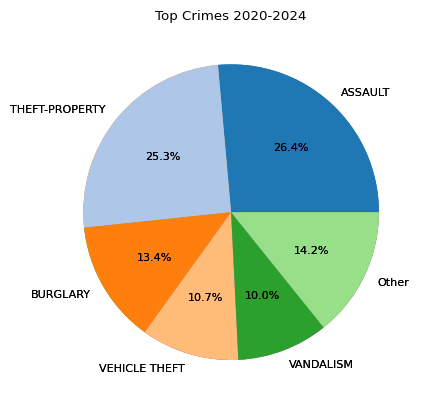

In [ ]:
#create a pie chart of the top crimes in the dataset
#group all other crimes into 'Other' category
num_primary_crimes = len(dm.data['Crm Secondary'].unique())
num_to_show = 5
top_crimes = dm.get_data_in_range(date_first, date_2021)['Crm Secondary'].value_counts()
#top_crimes.index = top_crimes.index.map(dm.crime_desc_dict)
other = top_crimes[num_to_show:].sum()
top_crimes = top_crimes[:num_to_show]
#append other to the end of top_crimes with the label 'Other'
top_crimes['Other'] = other

#reduce font size of pie chart labels
plt.rcParams.update({'font.size': 8})

plt.pie(top_crimes, labels=top_crimes.index, autopct='%1.1f%%')

#change coloring of pie chart
plt.gca().set_prop_cycle(None)
plt.pie(top_crimes, labels=top_crimes.index, autopct='%1.1f%%', colors=plt.cm.tab20.colors)

plt.title('Top Crimes 2020-2024')
plt.show()

In [ ]:
lat_long = data_2021.set_index(data_2021['datetime'])[['LAT', 'LON']]

#denormalize
lat_long['LAT'] = lat_long['LAT'] * (dm.lat_scaler[1] - dm.lat_scaler[0]) + dm.lat_scaler[0]
lat_long['LON'] = lat_long['LON'] * (dm.lon_scaler[1] - dm.lon_scaler[0]) + dm.lon_scaler[0]

#sort by datetime
lat_long = lat_long.sort_index()

date = lat_long.index[0]
end_date = lat_long.index[-1]

weekly_data = []

while date < end_date:
    #collect data within the week
    weekly_data.append(lat_long[(lat_long.index >= date) & (lat_long.index < date + pd.Timedelta(days=7))].values.tolist())
    date += pd.Timedelta(days=7)

weekly_clusters = []
for week_data in weekly_data:
    data, kmeans = cluster_kmeans(pd.DataFrame(week_data, columns=['LAT', 'LON']), ['LAT', 'LON'], 100)
    weekly_clusters.append(kmeans.cluster_centers_.tolist())

#use weekly bins for a geo stamped heatmap
la_coords = (34.0522, -118.2437)
m = folium.Map(location=la_coords, zoom_start=10)

HeatMapWithTime(weekly_data, radius=20, min_opacity=0, max_opacity=0.5, gradient={0.2: 'blue', 0.4: 'lime', 0.6: 'green', 0.9: 'yellow'}).add_to(m)
HeatMapWithTime(weekly_clusters, radius=50, min_opacity=0, max_opacity=0.5).add_to(m)

m.save('weekly_heatmap.html')


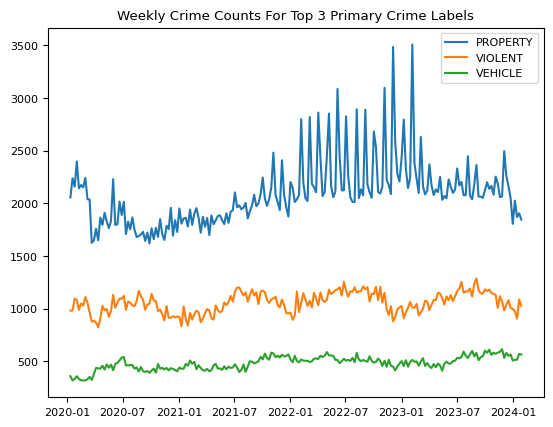

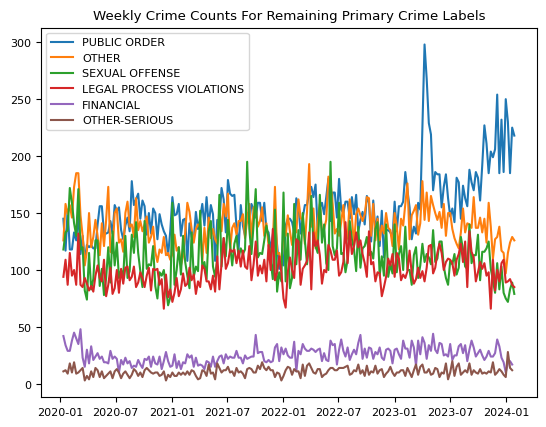

In [ ]:
#plot crime counts for each unique primary crime label
primaries = dm.data['Crm Primary'].unique().tolist()
crime_count_data = []
for primary in primaries:
    primary_data = dm.data[dm.data['Crm Primary'] == primary]
    crime_counts = get_crime_counts(primary_data, 'Crm Cd', freq='W')
    crime_count_data.append((primary, crime_counts, crime_counts.mean()))

crime_count_data = sorted(crime_count_data, key=lambda x: x[2], reverse=True)
#plot top 3
for i in range(3):
    primary, counts, mean = crime_count_data[i]
    plt.plot(counts[1:-2], label=primary)

plt.title('Weekly Crime Counts For Top 3 Primary Crime Labels')
plt.legend()
plt.show()

#plot the rest
for i in range(3, len(crime_count_data)):
    primary, counts, mean = crime_count_data[i]
    plt.plot(counts[1:-2], label=primary)

plt.title('Weekly Crime Counts For Remaining Primary Crime Labels')
plt.legend()
plt.show()

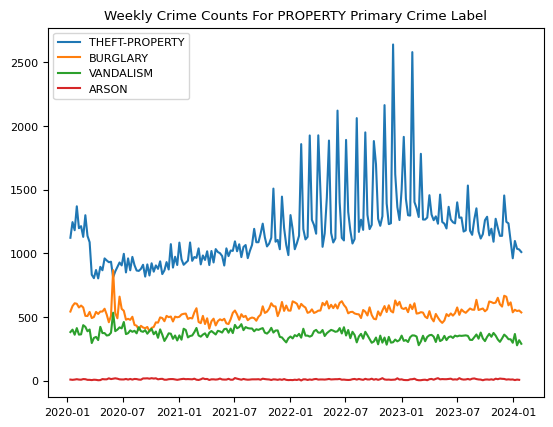

In [ ]:
#get unique secondary labels where primary label is 'PROPERTY'
property_data = dm.data[dm.data['Crm Primary'] == 'PROPERTY']
property_secondaries = property_data['Crm Secondary'].unique().tolist()
crime_count_data = []
for secondary in property_secondaries:
    secondary_data = property_data[property_data['Crm Secondary'] == secondary]
    crime_counts = get_crime_counts(secondary_data, 'Crm Cd', freq='W')
    crime_count_data.append((secondary, crime_counts, crime_counts.mean()))

crime_count_data = sorted(crime_count_data, key=lambda x: x[2], reverse=True)

#plot all
for secondary, counts, mean in crime_count_data:
    plt.plot(counts[1:-2], label=secondary)

plt.title('Weekly Crime Counts For PROPERTY Primary Crime Label')
plt.legend()
plt.show()

In [ ]:
#where secondary label is 'THEFT-PROPERTY', print the Crime Cd Desc and counts
theft_property_data = property_data[property_data['Crm Secondary'] == 'THEFT-PROPERTY']
theft_property_counts = theft_property_data['Crm Cd'].value_counts()
#save the codes of the top 6
top_theft_property = theft_property_counts[:6].index.tolist()
theft_property_counts.index = theft_property_counts.index.map(dm.crime_desc_dict)
print(theft_property_counts)

Crm Cd
THEFT OF IDENTITY                                           55326
THEFT PLAIN - PETTY ($950 & UNDER)                          45440
THEFT FROM MOTOR VEHICLE - PETTY ($950 & UNDER)             34252
THEFT FROM MOTOR VEHICLE - GRAND ($950.01 AND OVER)         31917
THEFT-GRAND ($950.01 & OVER)EXCPT,GUNS,FOWL,LIVESTK,PROD    29545
SHOPLIFTING - PETTY THEFT ($950 & UNDER)                    22461
BIKE - STOLEN                                                7299
BUNCO, GRAND THEFT                                           5770
SHOPLIFTING-GRAND THEFT ($950.01 & OVER)                     4564
THEFT, PERSON                                                3926
EMBEZZLEMENT, GRAND THEFT ($950.01 & OVER)                   3562
PICKPOCKET                                                   2543
BUNCO, PETTY THEFT                                           1924
THEFT FROM MOTOR VEHICLE - ATTEMPT                            837
THEFT PLAIN - ATTEMPT                                         444
BUN

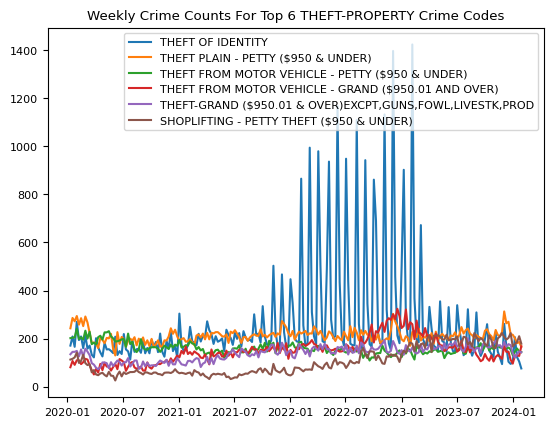

In [ ]:
#plot crime counts for top 6 theft-property codes
for code in top_theft_property:
    code_data = theft_property_data[theft_property_data['Crm Cd'] == code]
    counts = get_crime_counts(code_data, 'Crm Cd', freq='W')
    plt.plot(counts[1:-2], label=dm.crime_desc_dict[code])

plt.title('Weekly Crime Counts For Top 6 THEFT-PROPERTY Crime Codes')
plt.legend()
plt.show()

In [ ]:
from tensorflow.keras.models import Model
from tensorflow.keras.layers import LSTM, Dense, Input, Embedding, Flatten, Dropout
from tensorflow.keras.callbacks import EarlyStopping, ReduceLROnPlateau, Callback
from tensorflow.keras.regularizers import l2
from tensorflow.keras.utils import Sequence

from sklearn.model_selection import train_test_split
from sklearn.model_selection import TimeSeriesSplit

from tensorflow.keras.losses import mean_squared_error

from IPython.display import clear_output, HTML

In [ ]:
def create_sequences(data, seq_length, target_feature_indices):
    X, y = [], []
    for i in range(seq_length, len(data)):
        X.append(data[i-seq_length:i, :])
        y.append(data[i, target_feature_indices])
    return np.array(X), np.array(y).reshape(-1, 1)

def create_time_series_feature_data(data, seq_length, freq='W'):
    data = data.sort_values(by='datetime')

    #create a time series of crime counts for each day
    features = pd.DataFrame()

    features['count'] = get_crime_counts(data, 'Crm Cd', freq=freq)
    features['pct_diff'] = features['count'].pct_change()
    features['rolling_mean'] = features['count'].rolling(seq_length).mean()
    features['rolling_std'] = features['count'].rolling(seq_length).std()
    features['volatility'] = features['pct_diff'].rolling(seq_length).std()
    features['momentum'] = features['pct_diff'].rolling(seq_length).mean()

    #chop the last week
    features = features[:-1]

    #lagged features, use amount = seq_length
    for i in range(1, seq_length + 1):
        features[f't-{i}'] = features['count'].shift(i)

    features = features.dropna()

    scaler = MinMaxScaler()
    features = scaler.fit_transform(features)

    return np.array(features), scaler

def create_model(seq_length, num_features_in, num_features_out):

    #Crime count LSTM model
    input_shape = (seq_length, num_features_in)

    input_tensor = Input(shape=input_shape)

    x = input_tensor

    x = LSTM(256, return_sequences=True)(x)
    x = Dropout(0.2)(x)

    x = LSTM(512, return_sequences=True)(x)
    x = Dropout(0.2)(x)

    x = LSTM(512, return_sequences=False)(x)
    x = Dropout(0.2)(x)

    x = Dense(512, activation='relu')(x)
    x = Dropout(0.3)(x)

    x = Dense(256, activation='relu')(x)
    x = Dropout(0.2)(x)

    x = Dense(num_features_out, activation='linear')(x)

    model = Model(inputs=input_tensor, outputs=x)
    model.compile(optimizer='adam', loss='mean_squared_error')

    return model

def evaluate_model(model, X_test, y_test, scaler, target_feature_indices):

    target_feature_min = scaler.data_min_[target_feature_indices]
    target_feature_max = scaler.data_max_[target_feature_indices]

    y_pred = model.predict(X_test, verbose=0)

    #denormalize
    y_test = y_test * (target_feature_max - target_feature_min) + target_feature_min
    y_pred = y_pred * (target_feature_max - target_feature_min) + target_feature_min

    for i in range(len(target_feature_indices)):
        plt.plot(y_test[:, i], label='actual')
        plt.plot(y_pred[:, i], label='predicted')
        plt.title(f'Feature {target_feature_indices[i]}')
        plt.legend()
        plt.show()

class EpochLogger(Callback):
    def __init__(self, max_epochs):
        super().__init__()
        self.max_epochs = max_epochs

    def on_epoch_end(self, epoch, logs=None):
        clear_output(wait=True)
        loss = logs.get('loss', 'N/A')
        val_loss = logs.get('val_loss', 'N/A')
        print(f"Epoch {epoch+1}/{self.max_epochs} - loss: {loss:.4f} - val_loss: {val_loss:.4f}")




Epoch 95/300 - loss: 0.0117 - val_loss: 0.0094


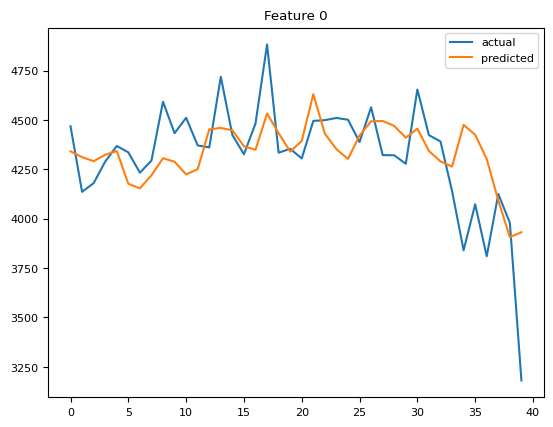

In [ ]:
#one model
seq_length = 3
time_series, scaler = create_time_series_feature_data(dm.data, seq_length)

X, y = create_sequences(time_series, seq_length, [0])

split_index = int(len(time_series) * 0.8)

X_train, X_test = X[:split_index], X[split_index:]
y_train, y_test = y[:split_index], y[split_index:]

solo_model = create_model(seq_length, X.shape[2], y.shape[1])

solo_model.fit(
        X_train, y_train,
        validation_data=(X_test, y_test),
        epochs=300, batch_size=256,
        verbose=0, callbacks=[
            EarlyStopping(monitor='val_loss', mode='min', verbose=0, patience=30, restore_best_weights=True),
            ReduceLROnPlateau(monitor='val_loss', factor=0.5, patience=15, verbose=0),
            EpochLogger(300)
        ]
    )

evaluate_model(solo_model, X_test, y_test, scaler, [0])

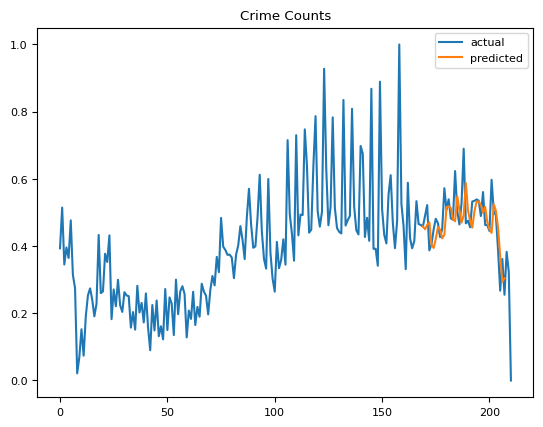

In [ ]:
#plot the true and predicted crime counts
#only predict past split_index, offset the predicted values by split_index
predictions = solo_model.predict(X[split_index+1:], verbose=0)[:, 0]
indices = range(split_index + 1, split_index + 1 + len(predictions))
plt.plot(time_series[:, 0], label='actual')
plt.plot(indices, predictions, label='predicted')
plt.title('Crime Counts')
plt.legend()
plt.show()

In [ ]:
#block cross-validation
seq_length = 3

time_series, scaler = create_time_series_feature_data(dm.data, seq_length)

X, y = create_sequences(time_series, seq_length, [0])

#use TimeSeriesSplit to split the data
tscv = TimeSeriesSplit(n_splits=2)

models = []
for train_index, test_index in tscv.split(X):

    X_train, X_test = X[train_index], X[test_index]
    y_train, y_test = y[train_index], y[test_index]

    model = create_model(seq_length, X.shape[2], y.shape[1])
    model.fit(
        X_train, y_train,
        validation_data=(X_test, y_test),
        epochs=300, batch_size=256,
        verbose=0, callbacks=[
            EarlyStopping(monitor='val_loss', mode='min', verbose=0, patience=30),
            ReduceLROnPlateau(monitor='val_loss', factor=0.5, patience=15, verbose=0),
            EpochLogger(300)
        ]
    )

    models.append(model)

In [ ]:
#plot actual vs predicted for each model in one plot
